In [1]:
%%capture
!pip install py7zr rouge_score

# Introduction
The goal of text summarization is to provide helpful and concise summaries for different types of text, such as documents, articles, or spoken conversations. A good summary covers the key points succinctly, and is fluent and grammatically correct. 
- extract key parts from the text and concatenate them together into a summary (i.e., extractive summarization).
- use natural language generation (NLG) techniques to summarize using novel words and phrases not necessarily present in the original text. This is referred to as abstractive summarization and is considered closer to how a person would generally summarize text. 

A main challenge with abstractive summarization, however, is that it sometimes struggles to generate accurate and grammatically correct summaries, especially in real world applications.


# SamSum Dataset
we’ll use the [**SAMSum**](https://huggingface.co/datasets/samsum) dataset developed by Samsung, which consists of a collection of dialogues along with brief summaries. In an enterprise setting, these dialogues might represent the interactions between a customer and the support center, so generating accurate summaries can help improve customer service and detect common patterns among customer requests. Let’s load it and look at an example:

In [2]:
from datasets import load_dataset

datasets = load_dataset('samsum')

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Dataset samsum downloaded and prepared to /root/.cache/huggingface/datasets/samsum/samsum/0.0.0/3f7dba43be72ab10ca66a2e0f8547b3590e96c2bd9f2cbb1f6bb1ec1f1488ba6. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

In [4]:
datasets['train'].to_pandas()

,id,dialogue,summary
0,13818513,Amanda: I baked cookies. Do you want some?\r\...,Amanda baked cookies and will bring Jerry some...
1,13728867,Olivia: Who are you voting for in this electio...,Olivia and Olivier are voting for liberals in ...
2,13681000,"Tim: Hi, what's up?\r\nKim: Bad mood tbh, I wa...",Kim may try the pomodoro technique recommended...
3,13730747,"Edward: Rachel, I think I'm in ove with Bella....",Edward thinks he is in love with Bella. Rachel...
4,13728094,Sam: hey overheard rick say something\r\nSam:...,"Sam is confused, because he overheard Rick com..."
...,...,...,...
14727,13863028,Romeo: You are on my ‘People you may know’ lis...,Romeo is trying to get Greta to add him to her...
14728,13828570,Theresa: <file_photo>\r\nTheresa: <file_photo>...,Theresa is at work. She gets free food and fre...
14729,13819050,John: Every day some bad news. Japan will hunt...,Japan is going to hunt whales again. Island an...
14730,13828395,Jennifer: Dear Celia! How are you doing?\r\nJe...,Celia couldn't make it to the afternoon with t...


In [5]:
print("\nDialogue:")
print(datasets['test'][0]['dialogue'])

print("\nSummary:")
print(datasets['test'][0]['summary'])


Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


The dialogues look like what you would expect from a chat via SMS or WhatsApp, including emojis and placeholders for GIFs. The dialogue field contains the full text and the summary the summarized dialogue.

In [6]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

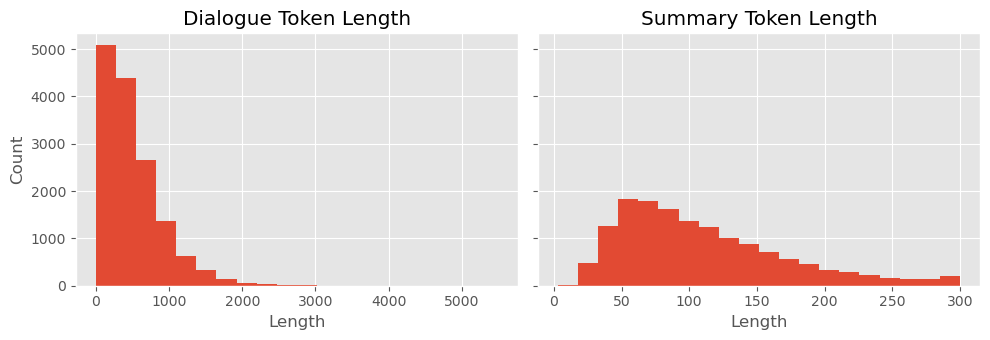

In [7]:
# let’s have a quick look at the length distribution of the input and outputs
d_len = [len(d) for d in datasets['train']['dialogue']]
s_len = [len(s) for s in datasets['train']['summary']]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20)
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(s_len, bins=20)
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [8]:
import numpy as np

# dialogue statistics
np.mean(d_len), np.median(d_len)

(511.18361390171054, 401.0)

In [9]:
# summary statistics
np.mean(s_len), np.median(s_len)

(110.13467282106978, 96.0)

In [10]:
# check small values
np.sort(d_len)[:10], np.sort(s_len)[:10]

(array([ 0, 31, 38, 39, 39, 42, 44, 44, 46, 46]),
 array([ 3,  4, 12, 13, 13, 14, 14, 15, 15, 15]))

In [11]:
# filter small values
datasets = datasets.filter(lambda x: len(x['dialogue'].split()) > 10)
datasets = datasets.filter(lambda x: len(x['summary'].split()) > 10)

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

We see that most dialogues are much short words -compared to other datasets sets such as CNN/DailyMail articles- with 400–512 tokens per dialogue. 
Similarly, the summaries are much shorter, with around 96–110 tokens (the average length of a tweet).

# Tokenization

In [12]:
from transformers import AutoTokenizer

checkpoint = 'sshleifer/distill-pegasus-cnn-16-4'
# checkpoint = 'google/mt5-small'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [13]:
# check if the fast version available
tokenizer.is_fast

True

In [14]:
inputs = tokenizer(datasets['test'][0]['summary'])
print(inputs)

{'input_ids': [12636, 397, 17379, 131, 116, 344, 155, 12195, 591, 131, 144, 133, 126, 107, 452, 397, 112, 471, 9915, 107, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [15]:
print(tokenizer.convert_ids_to_tokens(inputs.input_ids))

['▁Hannah', '▁needs', '▁Betty', "'", 's', '▁number', '▁but', '▁Amanda', '▁doesn', "'", 't', '▁have', '▁it', '.', '▁She', '▁needs', '▁to', '▁contact', '▁Larry', '.', '</s>']


The special Unicode character `▁` and end-of-sequence token `</s>` indicate that we’re dealing with the **SentencePiece** tokenizer which is based on the **Unigram segmentation** algorithm.

In [16]:
max_input_length = 512
max_target_length = 96

def tokenization(example_batch):
    model_inputs = tokenizer(example_batch['dialogue'], truncation=True, max_length=max_input_length)
    labels = tokenizer(example_batch['summary'], truncation=True, max_length=max_target_length)
    
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

tokenized_datasets = datasets.map(tokenization, batched=True, remove_columns=datasets['train'].column_names)

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [17]:
# inspect tokenized datasets 
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 11872
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 656
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 654
    })
})

# Metrics for text summarization

For summarization, one of the most commonly used metrics is the **ROUGE** score (short for *Recall-Oriented Understudy for Gisting Evaluation*). The basic idea behind this metric is to compare a generated summary against a set of reference summaries that are typically created by humans.

In [18]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [19]:
from datasets import load_metric

rouge_metric = load_metric('rouge')

One way to compare them could be to count the number of overlapping words, which in this case would be 6. However, this is a bit crude, so instead ROUGE is based on computing the precision and recall scores for the overlap.


To make this more precise, suppose we want to compare the following two summaries:

In [20]:
generated_summary = "I absolutely loved reading the Hunger Games"
reference_summary = "I loved reading the Hunger Games"

scores = rouge_metric.compute(
    predictions=[generated_summary], references=[reference_summary]
)
scores

{'rouge1': AggregateScore(low=Score(precision=0.8571428571428571, recall=1.0, fmeasure=0.923076923076923), mid=Score(precision=0.8571428571428571, recall=1.0, fmeasure=0.923076923076923), high=Score(precision=0.8571428571428571, recall=1.0, fmeasure=0.923076923076923)),
 'rouge2': AggregateScore(low=Score(precision=0.6666666666666666, recall=0.8, fmeasure=0.7272727272727272), mid=Score(precision=0.6666666666666666, recall=0.8, fmeasure=0.7272727272727272), high=Score(precision=0.6666666666666666, recall=0.8, fmeasure=0.7272727272727272)),
 'rougeL': AggregateScore(low=Score(precision=0.8571428571428571, recall=1.0, fmeasure=0.923076923076923), mid=Score(precision=0.8571428571428571, recall=1.0, fmeasure=0.923076923076923), high=Score(precision=0.8571428571428571, recall=1.0, fmeasure=0.923076923076923)),
 'rougeLsum': AggregateScore(low=Score(precision=0.8571428571428571, recall=1.0, fmeasure=0.923076923076923), mid=Score(precision=0.8571428571428571, recall=1.0, fmeasure=0.92307692307

🤗 Datasets actually computes *confidence intervals* for *precision*, *recall*, and *F1-score*; these are the low, mid, and high attributes.

- **Recall**: how much of the words in the reference summary have been produced by the model.
- **Percetion**: how much of the generated summary was relevant to the words in the refrence.
- **F1-score**: the harmonic mean of precision and recall.

### Rouge variants
- `rouge1` variant is the overlap of unigrams (single words).
- `rouge2` measures the overlap between bigrams (pairs of words), 
- `rougeL` and `rougeLsum` measure the longest matching sequences of words by looking for the longest common substrings in the generated and reference summaries.
    - `rougeL` is computed as the average over individual sentences.
    - `rougeLsum` refers to the fact that this metric is computed over a whole summary.

In [21]:
scores["rouge1"].mid  # 0.5 percentile

Score(precision=0.8571428571428571, recall=1.0, fmeasure=0.923076923076923)

The next thing we need to do is provide the trainer with a `compute_metrics()` function so that we can evaluate our model during training.<br>

For summarization this is a bit more involved than simply calling `rouge_score.compute()` on the model’s predictions, since we need to decode the outputs and labels into text before we can compute the **ROUGE** scores.<br>

The following function does exactly that, and also makes use of the `sent_tokenize()` function from `nltk` to separate the summary sentences with newlines:

In [22]:
import nltk
from nltk import sent_tokenize

nltk.download("punkt")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [23]:
def compute_metric(eval_pred):
    predictions, labels = eval_pred
    # Decode generated summaries into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    # Decode reference summaries into text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # ROUGE expects a newline after each sentence
    decoded_preds = ['\n'.join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ['\n'.join(sent_tokenize(label.strip())) for label in decoded_labels]
    # Compute ROUGE scores
    result = rouge_metric.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )
    # Extract the median scores
    result = {key: value.mid.fmeasure*100 for key, value in result.items()}
    return {k: round(v, 4) for k, v in result.items()}

# Model

`PEGASUS` pretraining task is intentionally similar to summarization: important sentences are removed/masked from an input document and are generated together as one output sequence from the remaining sentences, similar to an extractive summary.

`PEGASUS` is a state-of-the-art model for abstractive text summarization developed by Google Research. It uses an encoder-decoder model for sequence-to-sequence learning. In `PEGASUS` pre-training, several whole sentences are removed from documents and the model is tasked with recovering them. An example input for pre-training is a document with missing sentences, while the output consists of the missing sentences concatenated together.

In [24]:
from transformers import AutoModelForSeq2SeqLM
import torch


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = AutoModelForSeq2SeqLM.from_pretrained(checkpoint).to(device)

# Padding with DataCollator

Now, we need to create the data collator. This function is called in the `Trainer` just before the batch is fed through the model. <br>
In most cases we can use the default collator, which collects all the tensors from the batch and simply stacks them. For the summarization task we need to not only stack the inputs but also prepare the targets on the decoder side. <br> 
`PEGASUS` is an **encoder-decoder** transformer and thus has the classic **seq2seq** architecture. In a seq2seq setup, a common approach is to apply **“teacher forcing”** in the decoder. <br>
With this strategy, the decoder receives input tokens (like in decoder-only models such as `GPT-2`) that consists of the labels shifted by one in addition to the encoder output; so, when making the prediction for the next token the decoder gets the ground truth shifted by one as an input.

In [25]:
# teature forcing
import pandas as pd

text = ['PAD','Transformers', 'are', 'awesome', 'for', 'text', 'summarization']
rows = []

for i in range(len(text)-1):
    rows.append({'step':i+1, 'decoder_input': text[:i+1], 'label':text[i+1]})
pd.DataFrame(rows).set_index('step')

,decoder_input,label
step,,
1,[PAD],Transformers
2,"[PAD, Transformers]",are
3,"[PAD, Transformers, are]",awesome
4,"[PAD, Transformers, are, awesome]",for
5,"[PAD, Transformers, are, awesome, for]",text
6,"[PAD, Transformers, are, awesome, for, text]",summarization


We shift it by one so that the decoder only sees the previous ground truth labels and not the current or future ones. Shifting alone suffices since the decoder has
masked **self-attention** that masks all inputs at present and in the future.<br>

So, when we prepare our batch:
- we set up the decoder inputs by shifting the labels to the right by one. After that,
- we make sure the padding tokens in the labels are ignored by the loss function by setting them to –100. <br>

We actually don’t have to do this manually, though, since the `DataCollatorForSeq2Seq` comes to the rescue and takes care of all these steps for us.

In [26]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [27]:
# sanity check
features = [tokenized_datasets["train"][i] for i in range(2)]
data_collator(features)

You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'input_ids': tensor([[ 4776,   151,  4451,   108,   180,   131,   116,   164,   152,  5377,
           151,  6843,  4301, 83678,   108,   125,   140,   313,   112,   171,
          1425,   113,  1549,   155,  2371,   164, 64428,  4776,   151,   463,
           368,   119,   511,   124,   557,   152,  5377,   151,  4384,   119,
           235,   108, 18857,  1549,   111,  1596,  2073, 56616,   161,   418,
          5377,   151,  3183,  3469,   125,   131,   267,   696,   161,   130,
           116,   111,   171,   579,  5377,   151,   184,   195,   313,   112,
         38244,   114,  5713,   167,  1088,   113,  1553,   125,   131,   267,
          1461,   181, 38244,   316,  9609,  4776,   151,   321,   557,  1549,
           125,  1253,   881, 93882,  3111,   241,  4911,   207,  5033,   118,
           557, 18576,  4776,   151,   168,   288,  1107,  5377,   151,  1516,
           108,  1556,   125,   131,   267,   171,   120,  4776,   151,   125,
           163,   172,   303,   450,  

# Fine Tune

In [35]:
from transformers import Seq2SeqTrainingArguments

args = Seq2SeqTrainingArguments(
    output_dir='pegasus-samsum',
    num_train_epochs=1,
    learning_rate=3e-5,
    warmup_steps=500,
    optim='adamw_torch',
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    weight_decay=0.01,
    logging_steps=10,
    push_to_hub=False,
    disable_tqdm=False,
    report_to='none',
    evaluation_strategy='steps',
    eval_steps=500,
    save_steps=1e6,
    gradient_accumulation_steps=16,
    predict_with_generate=True,
)

- `predict_with_generate `argument has been set to indicate that we should generate summaries during evaluation so that we can compute **ROUGE** scores for each epoch.
- `save_total_limit` option to only save up to 3 checkpoints during training — this is because `PEGASUS` uses around more than a GB of hard drive space, and we can save a bit of room by limiting the number of copies we save.

In [36]:
torch.cuda.empty_cache()

In [37]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metric,
)

trainer.train()

Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
500,2.289100,1.965208,45.407300,22.395300,37.518700,41.857900


TrainOutput(global_step=742, training_loss=2.417408274833083, metrics={'train_runtime': 1192.8549, 'train_samples_per_second': 9.953, 'train_steps_per_second': 0.622, 'total_flos': 2846412481363968.0, 'train_loss': 2.417408274833083, 'epoch': 1.0})

In [38]:
trainer.evaluate()

{'eval_loss': 1.9186692237854004,
 'eval_rouge1': 46.4417,
 'eval_rouge2': 23.1115,
 'eval_rougeL': 38.4451,
 'eval_rougeLsum': 42.806,
 'eval_runtime': 150.1474,
 'eval_samples_per_second': 4.356,
 'eval_steps_per_second': 4.356,
 'epoch': 1.0}

# Inference

In [39]:
import transformers
transformers.logging.set_verbosity_error()

In [51]:
from transformers import pipeline

gen_kwargs = {"length_penalty":0.8, "num_beams":8, "max_length":256, 'top_k':50, 'top_p':0.9}
sample_text = datasets["test"][0]["dialogue"]
reference = datasets["test"][0]["summary"]
pipe = pipeline("summarization", model=model.cpu(), tokenizer=tokenizer)

print("Dialogue:")
print(sample_text)
print("\nReference Summary:")
print(reference)
print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Reference Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

Model Summary:
Amanda can't find Betty's number. Larry called her last time they were at the park together.


That looks much more like the reference summary. It seems the model has learned to synthesize the dialogue into a summary without just extracting passages. 
<br>
Now, the ultimate test: how well does the model work on a custom input?

In [52]:
custom_dialogue = """\
        Thom: Hi guys, have you heard of transformers?
        Lewis: Yes, I used them recently!
        Leandro: Indeed, there is a great library by Hugging Face.
        Thom: I know, I helped build it ;)
        Lewis: Cool, maybe we should write a book about it. What do you think?
        Leandro: Great idea, how hard can it be?!
        Thom: I am in!
        Lewis: Awesome, let's do it together!
        """
print(pipe(custom_dialogue, **gen_kwargs)[0]["summary_text"])

Thom and Leandro want to write a book about transformers.


# Resources
- [HuggingFace Course](https://huggingface.co/course/chapter7/5?fw=pt)
- [Pegasus model](https://huggingface.co/docs/transformers/model_doc/pegasus)
- [Rouge metric](https://huggingface.co/spaces/evaluate-metric/rouge)
- [Conversation Summaries in Google Chat](https://ai.googleblog.com/2022/11/conversation-summaries-in-google-chat.html)
- [Natural Language Processing with Transformers](https://transformersbook.com/)